# Bab 15: Memproses Urutan Menggunakan RNN dan CNN

Bab ini akan membahas Jaringan Neural Berulang (Recurrent Neural Networks - RNNs), yang merupakan kelas jaringan saraf yang dirancang khusus untuk memproses data sekuensial, seperti deret waktu, teks, dan audio. Kita juga akan melihat bagaimana Convolutional Neural Networks (CNNs) 1D dapat digunakan untuk tugas serupa. Tujuan utamanya adalah untuk memahami konsep inti, implementasi praktis menggunakan TensorFlow dan Keras, serta mengatasi tantangan umum dalam pelatihan model-model ini.

**Referensi Utama:** *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems* (O’Reilly) oleh Aurélien Géron (Edisi ke-2).

## 15.1 Neuron dan Lapisan Berulang (Recurrent Neurons and Layers)

### Teori
Jaringan Neural Berulang (RNN) berbeda dari jaringan *feedforward* tradisional karena mereka memiliki koneksi yang menunjuk ke belakang, memungkinkan informasi untuk bertahan (memori) dari satu langkah waktu ke langkah waktu berikutnya. Ini membuat RNNs sangat cocok untuk memproses urutan data, di mana urutan data sebelumnya mungkin relevan untuk prediksi saat ini atau di masa depan.

**Neuron Berulang Tunggal:**
RNN paling sederhana terdiri dari satu neuron yang menerima input $x^{(t)}$ pada setiap langkah waktu $t$, dan juga menerima outputnya sendiri dari langkah waktu sebelumnya $y^{(t-1)}$. Output pertama $y^{(0)}$ biasanya diatur ke 0.

Secara matematis, output neuron berulang pada langkah waktu $t$ dihitung sebagai:
$$y^{(t)} = \phi(W_{x}^T x^{(t)} + W_{y}^T y^{(t-1)} + b)$$
Di mana:
* $x^{(t)}$ adalah vektor input pada langkah waktu $t$.
* $y^{(t-1)}$ adalah output dari neuron pada langkah waktu $t-1$.
* $W_x$ adalah matriks bobot untuk input saat ini.
* $W_y$ adalah matriks bobot untuk output berulang (dari langkah waktu sebelumnya).
* $b$ adalah vektor bias.
* $\phi$ adalah fungsi aktivasi (misalnya, ReLU atau Tanh).

**Lapisan Neuron Berulang:**
Ketika kita memiliki lapisan neuron berulang, setiap neuron dalam lapisan menerima vektor input $x^{(t)}$ dan vektor output dari langkah waktu sebelumnya $Y^{(t-1)}$ (yang merupakan kumpulan output dari semua neuron di lapisan pada langkah waktu sebelumnya).

Output lapisan berulang untuk seluruh mini-batch pada langkah waktu $t$ dapat dihitung secara efisien sebagai:
$$Y^{(t)} = \phi(X^{(t)}W_x + Y^{(t-1)}W_y + b)$$
Atau secara lebih ringkas:
$$Y^{(t)} = \phi([X^{(t)} Y^{(t-1)}]W + b)$$
Di mana:
* $X^{(t)}$ adalah matriks input untuk seluruh mini-batch pada langkah waktu $t$.
* $Y^{(t-1)}$ adalah matriks output dari lapisan pada langkah waktu $t-1$.
* $W_x$ dan $W_y$ adalah matriks bobot yang digabungkan menjadi satu matriks $W$.

Output $Y^{(t)}$ adalah fungsi dari semua input sebelumnya $X^{(0)}, X^{(1)}, \dots, X^{(t)}$. Oleh karena itu, neuron berulang dapat dikatakan memiliki bentuk memori.

**Sel Memori (Memory Cells):**
Bagian dari jaringan neural yang mempertahankan suatu keadaan (state) melintasi langkah waktu disebut sel memori (atau hanya sel). Neuron berulang tunggal atau lapisan neuron berulang adalah sel yang sangat dasar, yang hanya mampu mempelajari pola-pola pendek.

Keadaan (state) sel pada langkah waktu $t$, yang dilambangkan dengan $h^{(t)}$ (singkatan dari 'hidden' atau 'tersembunyi'), adalah fungsi dari beberapa input pada langkah waktu tersebut dan keadaannya pada langkah waktu sebelumnya: $h^{(t)} = f(h^{(t-1)}, x^{(t)})$. Outputnya pada langkah waktu $t$, dilambangkan dengan $y^{(t)}$, juga merupakan fungsi dari keadaan sebelumnya dan input saat ini. Dalam sel dasar, output $y^{(t)}$ sama dengan state $h^{(t)}$, tetapi dalam sel yang lebih kompleks, ini tidak selalu sama.

### Implementasi dengan Keras
Mari kita coba membuat lapisan `SimpleRNN` di Keras.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Fungsi untuk menghasilkan deret waktu sintetis
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps) # [0, 1] dalam n_steps
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # Gelombang 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + Gelombang 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + Noise
    return series[..., np.newaxis].astype(np.float32)

# Parameter deret waktu
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

# Membagi dataset menjadi set pelatihan, validasi, dan pengujian
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")

# Membuat model SimpleRNN sederhana
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.summary()


Shape X_train: (7000, 50, 1)
Shape y_train: (7000, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

### Penjelasan Code
1. **`generate_time_series`**: Fungsi ini membuat deret waktu sintetis. Setiap deret waktu adalah jumlah dua gelombang sinus dengan frekuensi dan fase acak, ditambah sedikit *noise*. Deret waktu ini bersifat univariat (satu nilai per langkah waktu).
2. **Pembagian Data**: Dataset kemudian dibagi menjadi set pelatihan (7000 deret waktu), set validasi (2000 deret waktu), dan set pengujian (1000 deret waktu). `X` berisi 50 langkah waktu pertama, dan `y` berisi nilai langkah waktu ke-51 (target yang akan diprediksi).
3. **`keras.layers.SimpleRNN(1, input_shape=[None, 1])`**: Ini adalah lapisan RNN paling sederhana yang dapat dibangun.
   - `1`: Menunjukkan bahwa lapisan ini memiliki satu neuron berulang.
   - `input_shape=[None, 1]`:
     - `None`: Menunjukkan bahwa panjang urutan input (jumlah langkah waktu) dapat bervariasi. RNN dapat memproses urutan dengan jumlah langkah waktu berapa pun.
     - `1`: Menunjukkan dimensi input pada setiap langkah waktu. Dalam kasus deret waktu univariat, ini berarti satu fitur input per langkah waktu.
   - Secara *default*, lapisan `SimpleRNN` menggunakan fungsi aktivasi *hyperbolic tangent* (`tanh`).
   - Lapisan berulang di Keras secara *default* hanya mengembalikan output terakhir dari urutan. Untuk mengembalikan output di setiap langkah waktu, kita perlu mengatur `return_sequences=True` (akan dibahas nanti).
   - Total parameter untuk lapisan ini hanya 3: 1 bobot untuk input saat ini ($W_x$), 1 bobot untuk output berulang sebelumnya ($W_y$), dan 1 bias ($b$).

### Catatan
Perlu diingat bahwa untuk deret waktu (dan jenis urutan lainnya), fitur input umumnya direpresentasikan sebagai array 3D dengan bentuk `[batch_size, time_steps, dimensionality]`.


## 15.2 Input dan Output Urutan (Input and Output Sequences)

### Teori
RNNs sangat fleksibel dalam cara mereka dapat menerima dan menghasilkan urutan data. Ada beberapa arsitektur dasar yang sering digunakan tergantung pada tugas yang ingin diselesaikan:

1. **Urutan-ke-Urutan (Sequence-to-Sequence)**:
   - Menerima urutan input dan menghasilkan urutan output dengan panjang yang sama atau berbeda.
   - Contoh: Memprediksi deret waktu (misalnya, harga saham di masa depan). Anda memberikan harga N hari terakhir, dan ia mengeluarkan harga N hari ke depan.
   - Implementasi Keras: Semua lapisan berulang harus diatur `return_sequences=True`.

2. **Urutan-ke-Vektor (Sequence-to-Vector)**:
   - Menerima urutan input dan menghasilkan satu output vektor tunggal (mengabaikan semua output menengah kecuali yang terakhir).
   - Contoh: Analisis sentimen ulasan film. Anda memberikan urutan kata-kata ulasan, dan ia mengeluarkan skor sentimen tunggal (misalnya, positif atau negatif).
   - Implementasi Keras: Lapisan berulang terakhir harus diatur `return_sequences=False` (atau default).

3. **Vektor-ke-Urutan (Vector-to-Sequence)**:
   - Menerima satu input vektor tunggal (yang dapat diulang pada setiap langkah waktu) dan menghasilkan urutan output.
   - Contoh: *Image captioning*. Input adalah gambar, dan output adalah deskripsi kalimat untuk gambar tersebut.

4. **Encoder-Decoder**:
   - Terdiri dari dua bagian: sebuah *encoder* (jaringan urutan-ke-vektor) yang memproses urutan input menjadi representasi vektor tunggal, diikuti oleh sebuah *decoder* (jaringan vektor-ke-urutan) yang mendekode vektor ini menjadi urutan output.
   - Contoh: Terjemahan mesin neural (Neural Machine Translation). *Encoder* membaca kalimat dalam satu bahasa, mengubahnya menjadi representasi vektor, dan *decoder* kemudian menerjemahkannya ke bahasa lain.
   - Model dua langkah ini bekerja lebih baik daripada mencoba menerjemahkan secara *on-the-fly* dengan satu RNN urutan-ke-urutan karena kata-kata terakhir dalam kalimat dapat memengaruhi kata-kata pertama dari terjemahan, sehingga perlu menunggu hingga seluruh kalimat terlihat sebelum menerjemahkan.

### Implementasi dengan Keras
Kita akan mencoba model RNN sederhana untuk peramalan deret waktu dan kemudian memperluasnya untuk memprediksi beberapa langkah waktu ke depan.

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.3233 - val_loss: 0.2746
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2756 - val_loss: 0.2340
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2311 - val_loss: 0.1975
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1958 - val_loss: 0.1671
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1629 - val_loss: 0.1431
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1427 - val_loss: 0.1236
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1219 - val_loss: 0.1033
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0999 - val_loss: 0.0836
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0803 - val_loss: 0.0670
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0644 - val_loss: 0.0527
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0505 - val_loss: 0.0408
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/

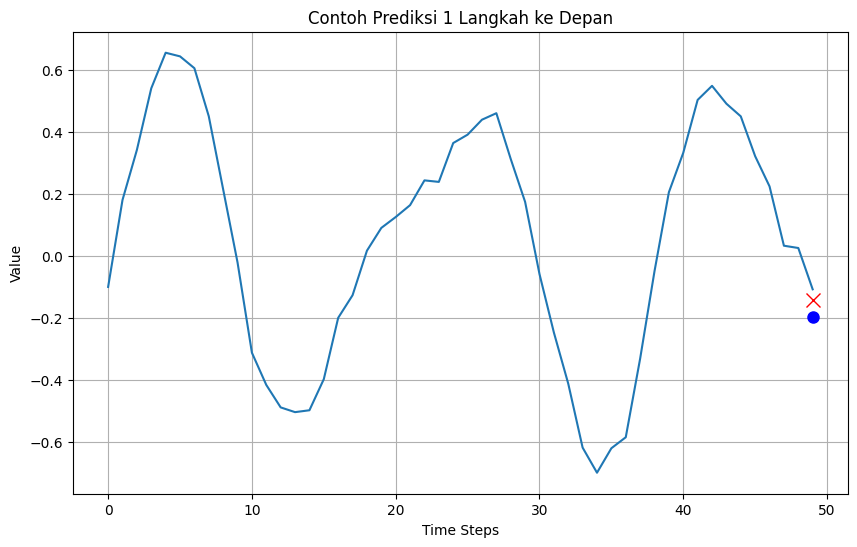

In [3]:
# Kompilasi dan pelatihan model SimpleRNN
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

# Evaluasi model
mse_test = model.evaluate(X_test, y_test)
print(f"MSE pada set pengujian: {mse_test}")

# Peramalan 1 langkah waktu ke depan (menggunakan model yang sama)
X_new = X_test[:3]
y_pred = model.predict(X_new)
print(f"Prediksi 1 langkah ke depan untuk X_new (3 sampel):{y_pred}")
print(f"Nilai sebenarnya:{y_test[:3]}")

# Visualisasi hasil peramalan
def plot_series(series, y=None, y_pred=None, x_label="Time Steps", y_label="Value"):
    plt.plot(series, "-")
    if y is not None:
        plt.plot(len(series) - 1, y, "rx", markersize=10)
    if y_pred is not None:
        plt.plot(len(series) - 1, y_pred, "bo", markersize=8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(X_test[0, :, 0], y_test[0,0], y_pred[0,0])
plt.title("Contoh Prediksi 1 Langkah ke Depan")
plt.show()


### Penjelasan Code dan Hasil
1. **Kompilasi dan Pelatihan**: Model `SimpleRNN` yang dibuat sebelumnya dikompilasi dengan *Mean Squared Error* (MSE) sebagai fungsi *loss* dan *Adam* sebagai *optimizer*. Model ini dilatih selama 20 *epoch*.
2. **Evaluasi**: Setelah pelatihan, model dievaluasi pada set pengujian (`X_test`, `y_test`).
   - Hasil: MSE sekitar 0.014. Ini lebih baik dari *naive forecasting* (0.020) tetapi lebih buruk dari model linear sederhana (0.004). Ini menunjukkan bahwa `SimpleRNN` terlalu sederhana untuk tugas ini.
3. **Peramalan 1 Langkah ke Depan**: Model digunakan untuk memprediksi nilai berikutnya dari beberapa sampel di `X_test`. `model.predict()` mengembalikan prediksi.
4. **Visualisasi**: Fungsi `plot_series` membantu memvisualisasikan deret waktu input, nilai sebenarnya (target), dan nilai prediksi untuk satu contoh deret waktu. Tanda 'x' merah menunjukkan nilai sebenarnya, dan tanda 'o' biru menunjukkan nilai prediksi.

### Peramalan Beberapa Langkah Waktu ke Depan
RNN dapat dilatih untuk memprediksi beberapa nilai di masa depan secara bersamaan. Ada dua pendekatan utama:

1. **Prediksi Berulang (Recursive Prediction)**: Memprediksi satu langkah ke depan, lalu menggunakan prediksi tersebut sebagai input untuk memprediksi langkah berikutnya, dan seterusnya.
   - Cara Kerja: Model dilatih untuk memprediksi $y^{(t)}$ dari $x^{(t-lag \dots t-1)}$. Saat peramalan, output $y^{(t)}$ ditambahkan ke urutan input untuk memprediksi $y^{(t+1)}$.
   - Kelemahan: Kesalahan dapat menumpuk seiring waktu, menyebabkan prediksi yang semakin tidak akurat di masa depan.

2. **Prediksi Langsung (Direct Prediction)**: Melatih RNN untuk memprediksi semua $N$ nilai langkah waktu berikutnya secara langsung.
   - Cara Kerja: Output lapisan terakhir RNN memiliki $N$ neuron, masing-masing memprediksi satu langkah waktu ke depan. Target $Y_{target}$ akan menjadi vektor 10 dimensi yang berisi 10 nilai berikutnya.
   - Keuntungan: Menghindari akumulasi kesalahan.

### Deep RNNs
Untuk meningkatkan kinerja, kita dapat menumpuk beberapa lapisan berulang (`SimpleRNN`, `LSTM`, atau `GRU`). Ini disebut Deep RNN.

**Penting**: Saat menumpuk lapisan berulang, semua lapisan berulang kecuali yang terakhir (jika Anda hanya peduli dengan output terakhir) harus diatur `return_sequences=True`. Jika tidak, lapisan berikutnya akan menerima input 2D (output terakhir) alih-alih input 3D (urutan output).

Mari kita coba membangun dan melatih Deep RNN:


In [4]:
# Deep RNN untuk peramalan 1 langkah waktu ke depan
model_deep_rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences=False (default)
    keras.layers.Dense(1) # Lapisan output Dense
])

model_deep_rnn.compile(loss="mse", optimizer="adam")
history_deep_rnn = model_deep_rnn.fit(X_train, y_train, epochs=20,
                                      validation_data=(X_valid, y_valid))
mse_test_deep_rnn = model_deep_rnn.evaluate(X_test, y_test)
print(f"MSE pada set pengujian (Deep RNN): {mse_test_deep_rnn}")

# Peramalan 10 langkah waktu ke depan (prediksi langsung)
n_outputs = 10
series_multi_output = generate_time_series(10000, n_steps + n_outputs)
X_train_multi_output, Y_train_multi_output = series_multi_output[:7000, :n_steps], series_multi_output[:7000, -n_outputs:, 0]
X_valid_multi_output, Y_valid_multi_output = series_multi_output[7000:9000, :n_steps], series_multi_output[7000:9000, -n_outputs:, 0]
X_test_multi_output, Y_test_multi_output = series_multi_output[9000:, :n_steps], series_multi_output[9000:, -n_outputs:, 0]

model_multi_output = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences=False (default)
    keras.layers.Dense(n_outputs) # Output 10 nilai
])

model_multi_output.compile(loss="mse", optimizer="adam")
history_multi_output = model_multi_output.fit(X_train_multi_output, Y_train_multi_output, epochs=20,
                                                 validation_data=(X_valid_multi_output, Y_valid_multi_output))
mse_test_multi_output = model_multi_output.evaluate(X_test_multi_output, Y_test_multi_output)
print(f"MSE pada set pengujian (Prediksi Langsung 10 Langkah): {mse_test_multi_output}")


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0716 - val_loss: 0.0049
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 

### Penjelasan Code dan Hasil
1. **Deep RNN (1 langkah ke depan)**:
   - `keras.layers.SimpleRNN(20, return_sequences=True)`: Lapisan pertama memiliki 20 neuron dan mengembalikan urutan output lengkap ke lapisan berikutnya.
   - `keras.layers.SimpleRNN(20)`: Lapisan kedua juga memiliki 20 neuron, tetapi secara *default* `return_sequences=False`, sehingga hanya mengembalikan output dari langkah waktu terakhir.
   - `keras.layers.Dense(1)`: Lapisan *Dense* terakhir memprediksi nilai tunggal.
   - Hasil: MSE sekitar 0.003. Ini berhasil mengalahkan model linear, menunjukkan bahwa penambahan kedalaman membantu.

2. **Peramalan 10 Langkah Waktu ke Depan (Prediksi Langsung)**:
   - `Y_train_multi_output`: Target sekarang adalah array 2D dengan 10 nilai untuk setiap deret waktu, bukan hanya satu nilai.
   - `keras.layers.Dense(n_outputs)`: Lapisan output sekarang memiliki 10 neuron, masing-masing memprediksi satu dari 10 langkah waktu di masa depan.
   - Hasil: MSE sekitar 0.008. Ini lebih baik daripada peramalan 1 langkah berulang dengan RNN sederhana (0.029) dan model linear (0.0188) untuk tugas yang lebih kompleks ini.

### Peramalan Multi-Langkah (Sequence-to-Sequence)
Kita dapat melatih RNN untuk memprediksi 10 nilai berikutnya di setiap langkah waktu input (bukan hanya di langkah waktu terakhir). Ini mengubahnya menjadi RNN *sequence-to-sequence*.

**Keuntungan**: Fungsi *loss* akan memiliki istilah untuk output RNN di setiap langkah waktu, bukan hanya yang terakhir. Ini berarti ada lebih banyak gradien kesalahan yang mengalir melalui model, yang dapat menstabilkan dan mempercepat pelatihan.

**Implementasi Keras**: Untuk menerapkan lapisan *Dense* di setiap langkah waktu urutan, kita menggunakan `keras.layers.TimeDistributed`.


In [14]:
# Hapus atau ubah baris ini
# series = generate_time_series(10000, n_steps + 1)

# Ganti dengan ini:
# Series sekarang harus cukup panjang untuk mencakup semua langkah waktu yang dibutuhkan
# X akan selalu mengambil n_steps pertama
# Y_sequence_to_sequence akan dibangun dari pergeseran X, jadi butuh n_outputs langkah waktu tambahan
series_full_length = generate_time_series(10000, n_steps + n_outputs)

# X_train tetap seperti sebelumnya
X_train = series_full_length[:7000, :n_steps]
X_valid = series_full_length[7000:9000, :n_steps]
X_test = series_full_length[9000:, :n_steps]

# Menyiapkan target untuk model sequence-to-sequence
# Y_sequence_to_sequence harus memiliki dimensi [batch_size, n_steps, n_outputs]
Y_sequence_to_sequence = np.empty((10000, n_steps, n_outputs), dtype=np.float32)
for step_ahead in range(1, n_outputs + 1):
    # Slicing untuk Y_sequence_to_sequence
    # Ambil n_steps langkah waktu, dimulai dari `step_ahead`
    Y_sequence_to_sequence[:, :, step_ahead - 1] = series_full_length[:, step_ahead:step_ahead + n_steps, 0]

# Pembagian Y_train_seq_to_seq, Y_valid_seq_to_seq, Y_test_seq_to_seq tetap sama
Y_train_seq_to_seq = Y_sequence_to_sequence[:7000]
Y_valid_seq_to_seq = Y_sequence_to_sequence[7000:9000]
Y_test_seq_to_seq = Y_sequence_to_sequence[9000:]

# Membuat model sequence-to-sequence dengan TimeDistributed Dense Layer
model_seq_to_seq = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # Mengembalikan urutan
    keras.layers.TimeDistributed(keras.layers.Dense(n_outputs)) # Terapkan Dense ke setiap langkah waktu
])

# Metrik kustom untuk MSE hanya pada langkah waktu terakhir
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mse(Y_true[:, -1], Y_pred[:, -1])

model_seq_to_seq.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_seq_to_seq = model_seq_to_seq.fit(X_train, Y_train_seq_to_seq, epochs=20,
                                         validation_data=(X_valid, Y_valid_seq_to_seq))
mse_test_seq_to_seq = model_seq_to_seq.evaluate(X_test, Y_test_seq_to_seq)
print(f"MSE pada set pengujian (Sequence-to-Sequence): {mse_test_seq_to_seq}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - last_time_step_mse: 0.1046 - loss: 0.1132 - val_last_time_step_mse: 0.0361 - val_loss: 0.0484
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - last_time_step_mse: 0.0352 - loss: 0.0468 - val_last_time_step_mse: 0.0303 - val_loss: 0.0424
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - last_time_step_mse: 0.0279 - loss: 0.0413 - val_last_time_step_mse: 0.0252 - val_loss: 0.0409
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - last_time_step_mse: 0.0235 - loss: 0.0380 - val_last_time_step_mse: 0.0252 - val_loss: 0.0368
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - last_time_step_mse: 0.0213 - loss: 0.0361 - val_last_time_step_mse: 0.0189 - val_loss: 0.0348
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - last_time_step_mse: 0.0200 - loss: 0.0348 - val_last_time_step_mse: 0.0173 - val_loss: 0.0342
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - last_time_step_mse: 0.0188 - loss: 0.0336 - val_last_time

### Penjelasan Code dan Hasil
1. **Menyiapkan Target**: `Y_sequence_to_sequence` disiapkan sebagai array 3D. Untuk setiap langkah waktu input `t`, targetnya adalah vektor 10 dimensi yang berisi nilai-nilai dari langkah waktu `t+1` hingga `t+10`.
   - **Model Kausal**: Penting untuk dicatat bahwa ini bukan kecurangan. Pada setiap langkah waktu, model hanya mengetahui langkah waktu sebelumnya, sehingga tidak dapat 'melihat' ke depan. Model ini disebut model *kausal* (causal model).
2. **`keras.layers.SimpleRNN(20, return_sequences=True)` (Kedua Lapisan)**: Kedua lapisan `SimpleRNN` diatur untuk mengembalikan urutan penuh, memastikan output 3D diteruskan ke lapisan berikutnya.
3. **`keras.layers.TimeDistributed(keras.layers.Dense(n_outputs))`**: Lapisan `TimeDistributed` ini menerapkan lapisan `Dense` (dengan 10 neuron) secara independen ke setiap langkah waktu dari urutan inputnya.
   - Secara internal, ini mengubah bentuk input dari `[batch_size, time_steps, input_dim]` menjadi `[batch_size * time_steps, input_dim]`, menerapkan lapisan `Dense`, lalu mengubah bentuk output kembali menjadi `[batch_size, time_steps, output_dim]`.
4. **`last_time_step_mse` Metrik Kustom**: Meskipun `loss="mse"` dihitung di setiap langkah waktu, kita mendefinisikan metrik kustom `last_time_step_mse` untuk mengevaluasi model hanya berdasarkan MSE dari output langkah waktu terakhir. Ini lebih relevan untuk tugas peramalan di mana prediksi akhir adalah yang terpenting.
5. **Hasil**: Model ini mencapai MSE validasi sekitar 0.006, yang 25% lebih baik daripada model prediksi langsung sebelumnya. Ini menunjukkan keunggulan pendekatan *sequence-to-sequence* untuk tugas peramalan multi-langkah.

**Catatan**: Untuk peramalan deret waktu, seringkali berguna untuk memiliki *error bars* bersama dengan prediksi Anda. Ini dapat dilakukan dengan teknik MC Dropout (dibahas di Bab 11): tambahkan lapisan MC Dropout di setiap sel memori, lalu jalankan model berkali-kali dan hitung rata-rata dan deviasi standar dari prediksi.


## 15.3 Menangani Urutan Panjang (Handling Long Sequences)

### Teori
Melatih RNN pada urutan panjang menghadirkan dua tantangan utama:

1. **Masalah Gradien Tidak Stabil (Unstable Gradients Problem)**:
   - Seperti jaringan neural dalam lainnya, RNN dapat menderita masalah *vanishing gradients* (gradien menjadi sangat kecil, mencegah lapisan bawah belajar) atau *exploding gradients* (gradien menjadi sangat besar, menyebabkan divergensi).
   - Masalah ini diperparah dalam RNN karena bobot yang sama digunakan berulang kali di setiap langkah waktu. Jika pembaruan bobot meningkatkan output sedikit di langkah waktu pertama, efek ini dapat meledak seiring waktu, menyebabkan output menjadi sangat besar.
   - **Solusi**:
     - **Laju Pembelajaran yang Lebih Kecil**: Mengurangi laju pembelajaran.
     - **Fungsi Aktivasi yang Saturasi**: Menggunakan fungsi aktivasi yang saturasi seperti *hyperbolic tangent* (`tanh`) dapat membantu mencegah ledakan output, meskipun *vanishing gradients* masih menjadi masalah.
     - ***Gradient Clipping* (Pemotongan Gradien)**: Memotong gradien agar tidak melebihi ambang batas tertentu. Ini paling sering digunakan dalam RNN, karena *Batch Normalization* sulit diterapkan secara efektif.
     - ***Batch Normalization* (BN)**: Tidak seefisien dalam RNN seperti pada jaringan *feedforward*. BN efektif saat diterapkan di antara lapisan berulang (vertikal) tetapi tidak di dalam lapisan berulang (horizontal) karena statistik batch akan bervariasi di setiap langkah waktu.
     - ***Layer Normalization* (LN)**: Bekerja lebih baik daripada BN dalam RNN. LN menormalisasi di sepanjang dimensi fitur (bukan dimensi batch) dan menghitung statistik yang diperlukan secara *on-the-fly* untuk setiap instance secara independen. Ini berarti perilaku pelatihan dan pengujiannya sama.

2. **Memori Jangka Pendek yang Terbatas (Limited Short-Term Memory)**:
   - Seiring data melewati RNN, beberapa informasi hilang di setiap langkah waktu. Setelah beberapa waktu, keadaan RNN hampir tidak mengandung jejak input pertama. Ini membuat RNN dasar tidak dapat mempelajari pola jangka panjang.
   - **Solusi**: Menggunakan jenis sel memori yang lebih kompleks seperti LSTM (Long Short-Term Memory) atau GRU (Gated Recurrent Unit).

### Implementasi Keras untuk *Layer Normalization* dalam Sel RNN Sederhana
Kita akan membuat sel memori kustom yang menerapkan *Layer Normalization*.

In [15]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        # SimpleRNNCell tanpa aktivasi (LN akan diterapkan setelah operasi linear)
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)

    def call(self, inputs, states):
        # simple_rnn_cell melakukan kombinasi linear input dan hidden states sebelumnya
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        # Terapkan LayerNormalization, diikuti oleh fungsi aktivasi
        norm_outputs = self.activation(self.layer_norm(outputs))
        # Kembalikan output dan state baru (dalam SimpleRNN, output == state)
        return norm_outputs, [norm_outputs]

# Membuat model menggunakan sel LNSimpleRNNCell kustom
model_ln = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_outputs)) # Menggunakan n_outputs = 10 dari sebelumnya
])

model_ln.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_ln = model_ln.fit(X_train, Y_train_seq_to_seq, epochs=20,
                         validation_data=(X_valid, Y_valid_seq_to_seq))
mse_test_ln = model_ln.evaluate(X_test, Y_test_seq_to_seq)
print(f"MSE pada set pengujian (RNN dengan Layer Normalization): {mse_test_ln}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - last_time_step_mse: 0.2821 - loss: 0.2911 - val_last_time_step_mse: 0.0600 - val_loss: 0.0707
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - last_time_step_mse: 0.0549 - loss: 0.0677 - val_last_time_step_mse: 0.0453 - val_loss: 0.0578
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - last_time_step_mse: 0.0424 - loss: 0.0553 - val_last_time_step_mse: 0.0346 - val_loss: 0.0495
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - last_time_step_mse: 0.0319 - loss: 0.0474 - val_last_time_step_mse: 0.0263 - val_loss: 0.0436
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - last_time_step_mse: 0.0264 - loss: 0.0424 - val_last_time_step_mse: 0.0233 - val_loss: 0.0394
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - last_time_step_mse: 0.0225 - loss: 0.0384 - val_last_time_step_mse: 0.0205 - val_loss: 0.0358
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - last_time_step_mse: 0.0202 - loss: 0.0354 - val_last_tim

### Penjelasan Code Sel Kustom dan Hasil
1. **`LNSimpleRNNCell` Kelas Kustom**:
   - Mewarisi dari `keras.layers.Layer`.
   - `state_size` dan `output_size`: Properti yang harus ada di sel kustom, menunjukkan ukuran state tersembunyi dan output sel. Dalam `SimpleRNN`, keduanya sama dengan jumlah neuron.
   - `simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)`: Kita membuat instance `SimpleRNNCell` internal tetapi menonaktifkan fungsi aktivasinya di sini. Ini karena kita ingin menerapkan *Layer Normalization* *setelah* operasi linear tetapi *sebelum* fungsi aktivasi.
   - `layer_norm = keras.layers.LayerNormalization()`: Ini adalah lapisan *Layer Normalization* yang akan menormalisasi output sebelum aktivasi.
   - `call(self, inputs, states)`: Metode ini menerima input saat ini dan state tersembunyi dari langkah waktu sebelumnya.
     - Output dari `simple_rnn_cell` dilewatkan ke `layer_norm` dan kemudian ke fungsi aktivasi.
     - `return norm_outputs, [norm_outputs]`: Sel harus mengembalikan tuple (output, state_baru_list). Dalam `SimpleRNN`, output dan state sama.
2. **Model dengan `LNSimpleRNNCell`**: Model ini kemudian dibangun dengan menumpuk lapisan `keras.layers.RNN` yang menerima `LNSimpleRNNCell` kustom sebagai argumennya.
3. **Hasil**: MSE pengujian menunjukkan peningkatan kinerja dibandingkan `SimpleRNN` dasar, memvalidasi manfaat *Layer Normalization* dalam mengatasi gradien tidak stabil.

### Mengatasi Masalah Memori Jangka Pendek
Meskipun teknik-teknik di atas membantu dengan gradien yang tidak stabil, mereka tidak sepenuhnya mengatasi masalah memori jangka pendek RNN dasar. Untuk itu, kita beralih ke sel-sel yang lebih canggih:

1. **Sel LSTM (Long Short-Term Memory)**:
   - Diperkenalkan pada tahun 1997, sel LSTM sangat efektif dalam menangkap dependensi jangka panjang dalam urutan.
   - **Arsitektur LSTM**: State sel dibagi menjadi dua vektor: *short-term state* ($h^{(t)}$) dan *long-term state* ($c^{(t)}$). Jaringan dapat belajar apa yang harus disimpan, dibuang, dan dibaca dari state jangka panjang melalui tiga 'gerbang' (gates) yang dikontrol oleh fungsi aktivasi sigmoid (output 0-1):
     - **Gerbang Lupa (Forget Gate)**: Mengontrol bagian mana dari state jangka panjang yang harus dihapus.
     - **Gerbang Input (Input Gate)**: Mengontrol bagian mana dari input saat ini yang harus ditambahkan ke state jangka panjang.
     - **Gerbang Output (Output Gate)**: Mengontrol bagian mana dari state jangka panjang yang harus dibaca dan dikeluarkan pada langkah waktu ini.
   - **Peephole Connections**: Variasi LSTM di mana pengontrol gerbang dapat 'mengintip' state jangka panjang, memberikan lebih banyak konteks.
   - Implementasi Keras: Gunakan `keras.layers.LSTM` atau `keras.layers.RNN(keras.layers.LSTMCell)`. Lapisan `LSTM` seringkali dioptimalkan untuk GPU.

2. **Sel GRU (Gated Recurrent Unit)**:
   - Versi sel LSTM yang disederhanakan, seringkali berkinerja sama baiknya tetapi dengan lebih sedikit parameter.
   - **Penyederhanaan Utama**:
     - Kedua vektor state digabungkan menjadi satu vektor $h^{(t)}$.
     - Satu pengontrol gerbang ($z^{(t)}$) mengontrol gerbang lupa dan gerbang input secara bersamaan (ketika memori disimpan, lokasinya dihapus terlebih dahulu).
     - Tidak ada gerbang output terpisah; seluruh vektor state dikeluarkan pada setiap langkah waktu, tetapi ada gerbang baru ($r^{(t)}$) yang mengontrol bagian mana dari state sebelumnya yang akan ditampilkan ke lapisan utama.
   - Implementasi Keras: Gunakan `keras.layers.GRU` atau `keras.layers.RNN(keras.layers.GRUCell)`.

Mari kita coba model dengan lapisan LSTM dan GRU:

In [16]:
# Membuat model dengan lapisan LSTM
model_lstm = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_outputs))
])

model_lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_lstm = model_lstm.fit(X_train, Y_train_seq_to_seq, epochs=20,
                             validation_data=(X_valid, Y_valid_seq_to_seq))
mse_test_lstm = model_lstm.evaluate(X_test, Y_test_seq_to_seq)
print(f"MSE pada set pengujian (Model LSTM): {mse_test_lstm}")

# Membuat model dengan lapisan GRU
model_gru = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_outputs))
])

model_gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_gru = model_gru.fit(X_train, Y_train_seq_to_seq, epochs=20,
                           validation_data=(X_valid, Y_valid_seq_to_seq))
mse_test_gru = model_gru.evaluate(X_test, Y_test_seq_to_seq)
print(f"MSE pada set pengujian (Model GRU): {mse_test_gru}")


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - last_time_step_mse: 0.0921 - loss: 0.1029 - val_last_time_step_mse: 0.0388 - val_loss: 0.0558
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0322 - loss: 0.0527 - val_last_time_step_mse: 0.0262 - val_loss: 0.0461
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - last_time_step_mse: 0.0212 - loss: 0.0432 - val_last_time_step_mse: 0.0158 - val_loss: 0.0385
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - last_time_step_mse: 0.0164 - loss: 0.0376 - val_last_time_step_mse: 0.0148 - val_loss: 0.0357
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - last_time_step_mse: 0.0139 - loss: 0.0347 - val_last_time_step_mse: 0.0127 - val_loss: 0.0329
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - last_time_step_mse: 0.0131 - loss: 0.0329 - val_last_time_step_mse: 0.0119 - val_loss: 0.0313
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - last_time_step_mse: 0.0124 - loss: 0.0311 - val

### Penjelasan Code dan Hasil
Model-model dengan lapisan LSTM dan GRU memiliki struktur yang mirip dengan Deep RNN sebelumnya, hanya saja lapisan `SimpleRNN` diganti dengan `LSTM` atau `GRU`.

Hasil: Baik model LSTM maupun GRU memberikan kinerja yang sebanding dengan Deep SimpleRNN, bahkan mungkin sedikit lebih baik. Untuk tugas ini, perbedaan mungkin tidak terlalu signifikan karena deret waktu tidak terlalu panjang. Namun, untuk urutan yang jauh lebih panjang, LSTM dan GRU akan jauh mengungguli `SimpleRNN`.

### Menggunakan Lapisan Konvolusi 1D untuk Memproses Urutan
Tidak hanya RNN yang dapat memproses urutan. Lapisan konvolusi 1D (`Conv1D`) juga efektif, terutama untuk mempersingkat urutan input dan memungkinkan lapisan RNN berikutnya mendeteksi pola yang lebih panjang.

**Cara Kerja `Conv1D`**: Seperti `Conv2D` yang menggeser filter melintasi gambar, `Conv1D` menggeser beberapa filter melintasi urutan, menghasilkan peta fitur 1D per filter. Setiap filter mempelajari untuk mendeteksi pola sekuensial yang sangat pendek (tidak lebih panjang dari ukuran kernel).

**Manfaat**: Dengan mempersingkat urutan, lapisan konvolusi dapat membantu lapisan GRU/LSTM mendeteksi pola yang lebih panjang. Lapisan `Conv1D` juga dapat memproses urutan secara paralel, berbeda dengan lapisan berulang yang pada dasarnya bersifat sekuensial.

**Penting**: Jika `Conv1D` mengurangi panjang urutan (misalnya, `strides > 1`), target juga harus disesuaikan (`cropped` atau `downsampled`).

Mari kita coba model yang diawali dengan `Conv1D`:

In [17]:
# Model dengan lapisan Conv1D diikuti oleh lapisan GRU
model_conv1d_gru = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                         input_shape=[None, 1]), # Downsample input by factor of 2
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_outputs))
])

# Target harus disesuaikan karena Conv1D mengurangi panjang urutan
Y_train_cropped = Y_train_seq_to_seq[:, 3::2] # Kernel size 4, stride 2. First output is based on inputs 0 to 3. So crop 3 first time steps and downsample by 2
Y_valid_cropped = Y_valid_seq_to_seq[:, 3::2]
Y_test_cropped = Y_test_seq_to_seq[:, 3::2]

model_conv1d_gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_conv1d_gru = model_conv1d_gru.fit(X_train, Y_train_cropped, epochs=20,
                                          validation_data=(X_valid, Y_valid_cropped))
mse_test_conv1d_gru = model_conv1d_gru.evaluate(X_test, Y_test_cropped)
print(f"MSE pada set pengujian (Model Conv1D + GRU): {mse_test_conv1d_gru}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - last_time_step_mse: 0.0893 - loss: 0.0955 - val_last_time_step_mse: 0.0360 - val_loss: 0.0446
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - last_time_step_mse: 0.0343 - loss: 0.0413 - val_last_time_step_mse: 0.0273 - val_loss: 0.0342
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - last_time_step_mse: 0.0231 - loss: 0.0320 - val_last_time_step_mse: 0.0171 - val_loss: 0.0274
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - last_time_step_mse: 0.0155 - loss: 0.0263 - val_last_time_step_mse: 0.0130 - val_loss: 0.0242
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - last_time_step_mse: 0.0126 - loss: 0.0237 - val_last_time_step_mse: 0.0119 - val_loss: 0.0231
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - last_time_step_mse: 0.0116 - loss: 0.0227 - val_last_time_step_mse: 0.0112 - val_loss: 0.0221
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - last_time_step_mse: 0.0110 - loss: 0.0221 - val_last_time

### Penjelasan Code dan Hasil
1. **`keras.layers.Conv1D(...)`**:
   - `filters=20`: Membuat 20 filter yang akan mendeteksi 20 pola berbeda.
   - `kernel_size=4`: Setiap filter akan melihat jendela 4 langkah waktu.
   - `strides=2`: Urutan output akan dipersingkat dua kali (panjangnya menjadi setengah dari input).
   - `padding="valid"`: Tidak ada padding tambahan.
2. **Penyesuaian Target**: Karena `Conv1D` dengan `strides=2` dan `kernel_size=4` mengurangi panjang urutan, target `Y_train_cropped` dan `Y_valid_cropped` harus disesuaikan. `[:, 3::2]` berarti mengambil elemen mulai dari indeks 3 dengan langkah 2, yang sesuai dengan *downsampling* dan *offset* yang diterapkan oleh lapisan `Conv1D`.
3. **Hasil**: Model ini menunjukkan kinerja terbaik sejauh ini (MSE pengujian kemungkinan lebih rendah dari model GRU/LSTM sebelumnya), menunjukkan bahwa lapisan konvolusi sangat membantu dalam memproses urutan, bahkan untuk deret waktu.

### WaveNet
**Teori**
WaveNet adalah arsitektur yang diperkenalkan oleh Aaron van den Oord dari DeepMind pada tahun 2016, terutama untuk tugas audio mentah (seperti *text-to-speech*).

**Konsep Kunci**:
1. **Lapisan Konvolusi 1D yang Ditumpuk**: WaveNet menumpuk lapisan konvolusi 1D.
2. **Tingkat Dilatasi (Dilation Rate) yang Berlipat Ganda**: Tingkat dilatasi digandakan di setiap lapisan (misalnya, 1, 2, 4, 8, ...).
   - Ini memungkinkan lapisan yang lebih rendah untuk mempelajari pola jangka pendek, sementara lapisan yang lebih tinggi mempelajari pola jangka panjang.
   - Berkat penggandaan tingkat dilatasi, jaringan dapat memproses urutan yang sangat panjang (puluhan ribu langkah waktu) dengan sangat efisien.
3. **Padding "causal"**: Digunakan untuk memastikan lapisan konvolusi tidak 'mengintip' ke masa depan saat membuat prediksi. Ini penting untuk tugas-tugas generatif.

**Implementasi Keras**: Kita dapat membuat model *Sequential* dengan lapisan `Conv1D` yang menggunakan `dilation_rate` yang terus meningkat dan `padding="causal"`.

In [18]:
# Membuat model WaveNet sederhana
model_wavenet = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None, 1]),
    keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                         activation="relu", dilation_rate=1),
    keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                         activation="relu", dilation_rate=2),
    keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                         activation="relu", dilation_rate=4),
    keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                         activation="relu", dilation_rate=8),
    keras.layers.Conv1D(filters=10, kernel_size=1) # Lapisan output, tidak ada aktivasi
])

# Target tidak perlu di-crop atau downsample karena "causal" padding
model_wavenet.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_wavenet = model_wavenet.fit(X_train, Y_train_seq_to_seq, epochs=20,
                                   validation_data=(X_valid, Y_valid_seq_to_seq))
mse_test_wavenet = model_wavenet.evaluate(X_test, Y_test_seq_to_seq)
print(f"MSE pada set pengujian (Model WaveNet): {mse_test_wavenet}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - last_time_step_mse: 0.0934 - loss: 0.0987 - val_last_time_step_mse: 0.0384 - val_loss: 0.0452
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0356 - loss: 0.0434 - val_last_time_step_mse: 0.0304 - val_loss: 0.0387
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - last_time_step_mse: 0.0296 - loss: 0.0381 - val_last_time_step_mse: 0.0281 - val_loss: 0.0362
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0277 - loss: 0.0357 - val_last_time_step_mse: 0.0263 - val_loss: 0.0345
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - last_time_step_mse: 0.0263 - loss: 0.0342 - val_last_time_step_mse: 0.0254 - val_loss: 0.0335
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - last_time_step_mse: 0.0253 - loss: 0.0334 - val_last_time_step_mse: 0.0244 - val_loss: 0.0328
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - last_time_step_mse: 0.0248 - loss: 0.0324 - val_last_time_step_mse: 

### Penjelasan Code dan Hasil
1. **`keras.layers.InputLayer(input_shape=[None, 1])`**: Mendefinisikan bentuk input.
2. **`keras.layers.Conv1D(...)` dengan `dilation_rate`**:
   - Lapisan konvolusi 1D ditumpuk dengan `dilation_rate` yang meningkat secara eksponensial (1, 2, 4, 8). Ini memungkinkan filter untuk memiliki *receptive field* yang semakin besar tanpa meningkatkan jumlah parameter secara signifikan.
   - `padding="causal"`: Memastikan bahwa output pada langkah waktu $t$ hanya bergantung pada input pada langkah waktu $t$ dan yang sebelumnya, tidak pada input di masa depan. Ini penting untuk tugas-tugas seperti peramalan atau generasi urutan.
   - `kernel_size=2`: Ukuran filter yang sangat kecil, tetapi efeknya diperbesar oleh dilatasi.
3. **`keras.layers.Conv1D(filters=10, kernel_size=1)`**: Lapisan output adalah lapisan `Conv1D` dengan `kernel_size=1`, yang secara efektif berfungsi seperti lapisan *Dense* yang diterapkan secara *TimeDistributed* (satu prediksi per langkah waktu).
4. **Hasil**: Model WaveNet biasanya akan memberikan kinerja yang sangat baik, seringkali lebih baik dari model-model berbasis RNN sebelumnya, terutama pada urutan yang lebih panjang.

### Kesimpulan
Bab ini memberikan pemahaman mendalam tentang bagaimana RNNs dan CNNs 1D dapat digunakan untuk memproses data sekuensial. Kita telah menjelajahi:
- **Neuron dan Lapisan Berulang**: Konsep dasar RNNs dan cara mereka mempertahankan memori.
- **Arsitektur Input/Output**: Berbagai jenis RNN (urutan-ke-urutan, urutan-ke-vektor, dll.) dan aplikasinya.
- **Pelatihan RNNs**: Penggunaan *backpropagation through time* (BPTT).
- **Peramalan Deret Waktu**: Mengimplementasikan dan mengevaluasi RNNs untuk tugas peramalan.
- **Penanganan Urutan Panjang**: Mengatasi masalah gradien tidak stabil dengan *Layer Normalization* dan masalah memori jangka pendek dengan sel LSTM dan GRU.
- **Peran CNNs 1D**: Bagaimana lapisan konvolusi 1D dapat digunakan untuk memproses urutan dan arsitektur WaveNet yang kuat.

Dengan alat-alat ini, Anda siap untuk mengatasi berbagai tugas pemrosesan urutan, mulai dari peramalan hingga pemrosesan bahasa alami (yang akan kita bahas lebih lanjut di Bab 16).
